## 爬取NSB杭州工会BBS
---
**环境**：
- Python 3.5+
- requests 2.11.1
- lxml 3.8.0
- openpyxl 2.4.8
- pandas 0.18.1
- seaborn 0.7.1
- matlibplot 2.0.0
- numpy 1.11.3+mkl

**功能**
- 爬取NSB杭州工会BBS发帖信息

**历史**
- 0.01: 2017/08/12

**TO DO**
- 重构Code

In [1]:
import requests
import urllib.parse

from lxml import etree
from io import StringIO

import datetime
import time
import os
import sys
import random

import pandas as pd

#===========================================================================================
# 从wireshark中得到如下实际登陆网址，注意登陆网址不是'http://www.nsntradeunion.com.cn/bbs/mvnforum/login'
url_login = 'http://www.nsntradeunion.com.cn/bbs/mvnforum/loginprocess'
base_url = 'http://www.nsntradeunion.com.cn/bbs/mvnforum/'

# HTTP消息头
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:45.0) Gecko/20100101 Firefox/45.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-Language': 'zh-CN,zh;q=0.8,en-US;q=0.6,en;q=0.4',
    'Upgrade-Insecure-Requests': '1',
    'Cache-Control': 'max-age=0',
    'Keep-Alive': 'timeout=60, max=10',
}
# HTTP登陆需要携带的数据，登陆密码经过加密，从wireshark可以获取该编码
payload = {
    'MemberName': '00000000',
    'MemberMatkhau': '',
    'md5pw': 'EcVhldcfLBOR7NJhScfvBA==',
    'url': '',
    # 保持自动登陆状态
    'AutoLogin': 'yes',
    'AutoLoginExpire': "2592000"    
}

#============================================================================================
# 获取网址内容，输入url，输出url内容
def download_url(url, headers):
    if url is None:
        return None
    # 防止爬取网站屏蔽，增加爬取时间间隔  
    time.sleep(random.randint(0,10))
    content = session.get(url, headers=headers)
    if content.status_code != 200:
        return None
    return content

# 解析网页返回element tree
def parse_url(content):
    parser = etree.HTMLParser()
    tree = etree.parse(StringIO(content.text), parser)    
    return tree

def login(url, headers=headers, data=payload):  
    # POST方法使用用户名和密码登陆，会返回index page：http://www.nsntradeunion.com.cn/bbs/mvnforum/index
    index_page = session.post(url, headers=headers, data=payload)
    if index_page.status_code != 200:
        return None    
    
    return index_page

# 判断是否登陆成功
def is_login(index_page):
    parser = etree.HTMLParser()
    tree = etree.parse(StringIO(index_page.text), parser)
    # 如果登陆成功，在如下path可以找到myprofile节点，否则说明登陆失败
    index = tree.xpath('//table/tr/td[1]/a[@href="myprofile"]')    
    if index != []:
        return True
    else:
        return False

# 获取所有板块的完整网址
def get_board_urls(index_page):
    board_urls = []
    tree = parse_url(index_page)

    # 找到Section名字
#     section_name = tree.xpath('//tr[@class="portlet-section-subheader"]/td/b/text()')
#     print('版块区名称：\n', section_name)
    # 找到所有板块子link（比如：'listthreads?forum=1'）
    board_urls = tree.xpath('//tbody/tr/td/a[contains(@class, "messageTopic")]/@href')
    
    return board_urls

def get_next_page(tree):
        # 获取当前页面下一页网址
        if (tree.xpath('//a[text()="下一页"]') != []):
            next_page_url = tree.xpath('//a[text()="下一页"]')[0].attrib['href'].strip()
        else:
            next_page_url = None  
        
        return next_page_url

# 解析每一个板块的页面，获取板块的每一个页面，并解析每一个发帖并将结果保存到post_list
def parse_board_url(next_page_url, post_data_list):
#     count = 0  # For debugging
    # 如果板块页面不是最后一页（最后一页没有下一页），则继续解析每一个页面的发帖
    while (next_page_url != None):
#         count += 1 # For debugging
        # 和base_url组成完整的link（'http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1'）    
        next_page_url = urllib.parse.urljoin(base_url, next_page_url)  
        # 获取板块页面的内容
        print("Start to parse page:", next_page_url)
        next_page_url_content = download_url(next_page_url, headers=headers)
        # 解析返回内容为element tree
        tree = parse_url(next_page_url_content)
        # 获取板块名称
        board_name = tree.xpath('//tr[contains(@class,"nav")]/td[2]/text()[3]')[0].strip().split(':')[-1]
        # 获取当前页面的所有帖子的参考节点
        post_root_list = tree.xpath('//tr[contains(@class,"portlet-section-alternate")]') 
        # 将当前页面参考节点加入到发帖列表里面并返回
        for post_root in post_root_list:
            post_data = parse_post_url(post_root, board_name)
            # BBS中每个版块的每一页都会有大量相同的置顶帖子，需要去重
            if post_data not in post_data_list:
                post_data_list.append(post_data)

        next_page_url = get_next_page(tree)  
        
#         if count>0:  # For debugging
#             return post_data_list  
    return post_data_list
        
# 解析每一个发帖内容并保存结果        
def parse_post_url(post_root, board_name):
    post_data = {}
    post_data['版块'] = board_name
    post_data['标题'] = post_root.xpath('./td[3]/a/text()')[0].strip()
    post_data['链接'] = post_root.xpath('./td[3]/a/@href')[0].strip()
    post_data['作者'] = post_root.xpath('./td[4]/a/text()')[0].strip()
    post_data['作者ID'] = post_root.xpath('./td[4]/a/@href')[0].strip().split("=")[1]
    post_data['回复数'] = post_root.xpath('./td[5]/b/text()')[0].strip()
    post_data['浏览数'] = post_root.xpath('./td[6]/b/text()')[0].strip()
    post_data['最后回复日期'] = post_root.xpath('./td[7]/text()')[0].strip()
    
    return post_data

#  将爬取结果保存到csv，需要pip安装openpyxl
def save_parse_data(post_data_list):
    df = pd.DataFrame(post_data_list)
    current_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    filename = 'nsnbbs' + current_time + '.csv'
    file = df.to_csv(filename)
    print("Crawled data saved in file:", filename)

In [2]:
with requests.Session() as session:
    index_page = login(url_login)
    
    if is_login(index_page):
        print("Login successfully!")
    else:
        print("Login failed, exit!")
    
    post_data_list = []
    board_urls = get_board_urls(index_page)
    print("Start to crawl NSB BBS at:", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    for board_url in board_urls:
        print("Start to parse board:", board_url)
        post_data_list = parse_board_url(board_url, post_data_list)
    print("Crawl finished at:", datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print("Total %d posts are crawled!"%len(post_data_list))  
    save_parse_data(post_data_list)

Login successfully!
Start to crawl NSB BBS at: 2017-08-13 22:13:05
Start to parse board: listthreads?forum=7
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=10
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=20
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=30
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=40
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=50
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=60
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=70
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=80
Start to parse page: http://www.nsntr

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=850
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=860
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=870
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=880
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=890
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=900
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=910
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=7&offset=920
Start to parse board: listthreads?forum=8
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=8
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=8&offset=10


Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=20
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=30
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=40
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=50
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=60
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=70
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=80
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=90
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=100
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=26&offset=110
Start to parse page: http://

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=300
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=310
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=320
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=330
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=340
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=350
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=360
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=370
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=380
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=390
Start to parse page: http://ww

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1150
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1160
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1170
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1180
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1190
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1200
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1210
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1220
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1230
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=1&offset=1240
Start to parse page:

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=220
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=230
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=240
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=250
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=260
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=270
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=280
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=290
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=300
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=3&offset=310
Start to parse page: http://ww

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=80
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=90
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=100
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=110
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=120
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=130
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=140
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=150
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=160
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=5&offset=170
Start to parse page: http://www.

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=650
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=660
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=670
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=680
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=690
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=700
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=710
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=720
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=730
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=6&offset=740
Start to parse page: http://ww

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=450
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=460
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=470
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=480
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=490
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=500
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=510
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=520
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=530
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=12&offset=540
Start to parse page:

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=690
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=700
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=710
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=720
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=730
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=740
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=750
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=760
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=770
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=13&offset=780
Start to parse page:

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=10
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=20
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=30
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=40
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=50
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=60
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=70
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=80
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=90
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=14&offset=100
Start to parse page: http://w

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=380
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=390
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=400
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=410
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=420
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=430
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=440
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=450
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=460
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=10&offset=470
Start to parse page:

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=20
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=30
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=40
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=50
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=60
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=70
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=80
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=90
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=100
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=37&offset=110
Start to parse page: http://

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=430
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=440
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=450
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=460
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=470
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=480
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=490
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=500
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=510
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=520
Start to parse page:

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1270
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1280
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1290
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1300
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1310
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1320
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1330
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1340
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1350
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=1360
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2100
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2110
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2120
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2130
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2140
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2150
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2160
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2170
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2180
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2190
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2930
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2940
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2950
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2960
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2970
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2980
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=2990
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3000
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3010
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3020
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3760
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3770
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3780
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3790
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3800
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3810
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3820
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3830
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3840
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=3850
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4590
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4600
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4610
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4620
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4630
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4640
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4650
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4660
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4670
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=4680
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5420
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5430
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5440
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5450
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5460
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5470
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5480
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5490
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5500
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=5510
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6250
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6260
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6270
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6280
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6290
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6300
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6310
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6320
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6330
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=6340
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7080
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7090
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7100
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7110
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7120
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7130
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7140
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7150
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7160
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=18&offset=7170
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=110
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=120
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=130
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=140
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=150
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=160
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=170
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=180
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=190
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=200
Start to parse page:

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=950
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=960
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=970
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=980
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=990
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1000
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1010
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1020
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1030
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1040
Start to parse 

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1780
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1790
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1800
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1810
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1820
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1830
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1840
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1850
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1860
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=19&offset=1870
Start to p

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=30
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=40
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=50
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=60
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=70
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=80
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=90
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=100
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=110
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=36&offset=120
Start to parse page: http:/

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=110
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=120
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=130
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=140
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=150
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=160
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=170
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=180
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=190
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=17&offset=200
Start to parse page:

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=30&offset=90
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=30&offset=100
Start to parse board: listthreads?forum=33
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33&offset=10
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33&offset=20
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33&offset=30
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33&offset=40
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33&offset=50
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33&offset=60
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=33&offset

Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=35&offset=270
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=35&offset=280
Start to parse board: listthreads?forum=32
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32&offset=10
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32&offset=20
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32&offset=30
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32&offset=40
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32&offset=50
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32&offset=60
Start to parse page: http://www.nsntradeunion.com.cn/bbs/mvnforum/listthreads?forum=32&offse

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

# 为pyplot设置中文字体
pylab.mpl.rcParams['font.sans-serif'] = ['SimHei']
pylab.mpl.rcParams['axes.unicode_minus'] = False

import os

import warnings
warnings.filterwarnings('ignore')

BBS_DATA_FILE_PATH = 'D:\Code\GitHub\crawler'
FILENAME = 'nsnbbs20170814015043.csv'

def load_data(bbs_file_path=BBS_DATA_FILE_PATH, bbs_file_name=FILENAME):
    file = os.path.join(bbs_file_path, bbs_file_name)
    csv_data = pd.read_csv(file, encoding='gbk')
    return csv_data   

In [4]:
# 整理数据，对列标签进行排序
bbs_data = load_data()
bbs_data = bbs_data.iloc[:,1:]
bbs_data = bbs_data[['标题','作者','浏览数','回复数','版块','最后回复日期','作者ID','链接']]
bbs_data.info()
# 可以看出标题列有4个标题为NULL,作者列有200个作者为NULL。使用''替代NULL
bbs_data.replace(np.nan, '', inplace=True)
bbs_data.drop_duplicates(subset=['链接'], inplace=True)
bbs_data.info()
bbs_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24470 entries, 0 to 24469
Data columns (total 8 columns):
标题        24466 non-null object
作者        24270 non-null object
浏览数       24470 non-null int64
回复数       24470 non-null int64
版块        24470 non-null object
最后回复日期    24470 non-null object
作者ID      24470 non-null object
链接        24470 non-null object
dtypes: int64(2), object(6)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24118 entries, 0 to 24469
Data columns (total 8 columns):
标题        24118 non-null object
作者        24118 non-null object
浏览数       24118 non-null int64
回复数       24118 non-null int64
版块        24118 non-null object
最后回复日期    24118 non-null object
作者ID      24118 non-null object
链接        24118 non-null object
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


,浏览数,回复数
count,24118.000000,24118.000000
mean,287.824654,3.081972
std,1567.810427,8.124903
min,0.000000,0.000000
25%,56.000000,0.000000
50%,128.000000,1.000000
75%,267.000000,3.000000
max,206594.000000,252.000000


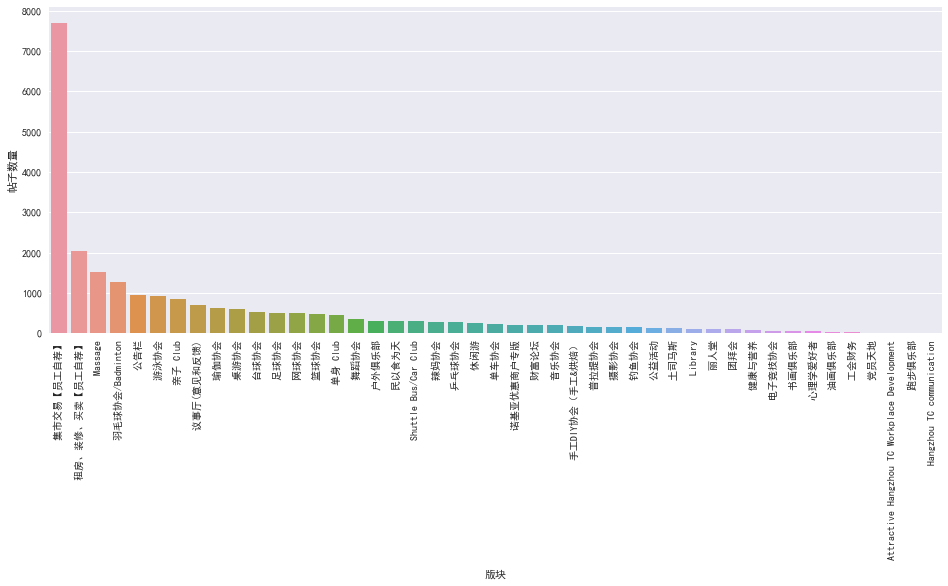

In [5]:
# 各版块帖子数量柱状图
fig = plt.figure(figsize=(16,6))
# Series.value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True). Returns object containing counts of unique values.
# 版块受欢迎程度排序（按版块发帖数量多少排序）
ax = sns.countplot('版块', data=bbs_data, order=bbs_data['版块'].value_counts().index)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set_ylabel('帖子数量')
plt.show()

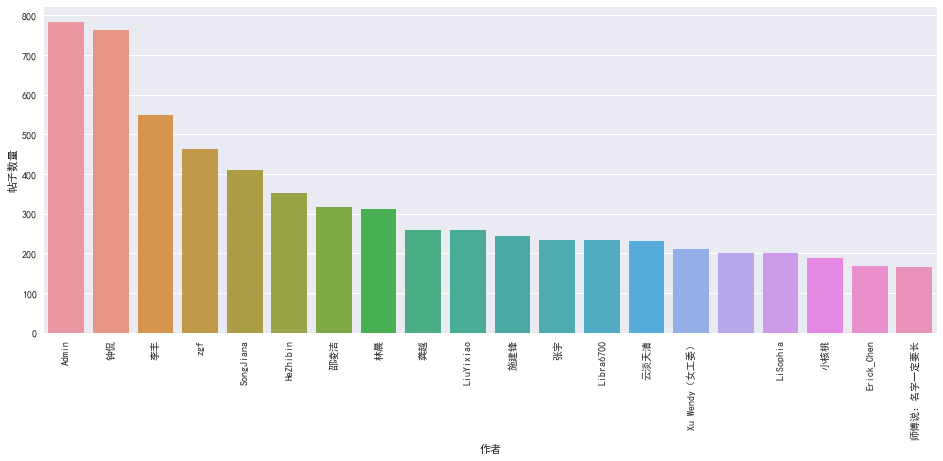

In [6]:
# 发帖数目最多的前20位作者
fig = plt.figure(figsize=(16,6))
ax = sns.countplot('作者', data=bbs_data, order=bbs_data['作者'].value_counts().iloc[:20].index)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set_ylabel('帖子数量')
plt.show()

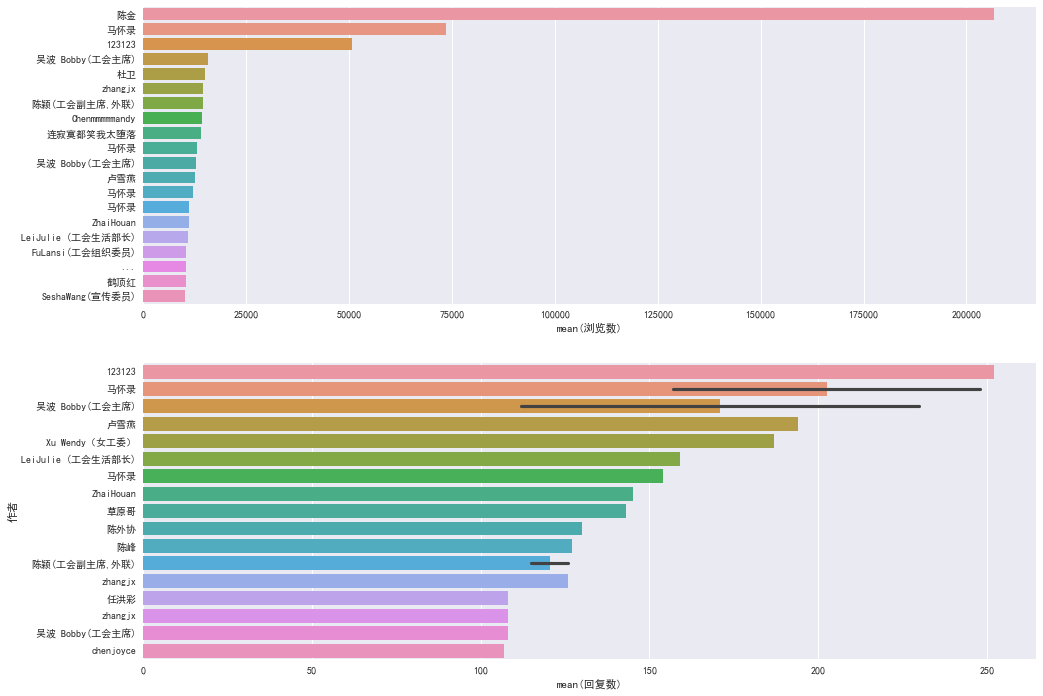

In [7]:
# 前20个最受欢迎的帖子的作者（浏览数最多，回复数最多）
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sorted_data_views = bbs_data.sort_values(by='浏览数', ascending=False).iloc[:20]
# 参考：https://stackoverflow.com/questions/41192997/separate-out-and-keep-duplicate-categorical-data-using-seaborn-barplot
# 如果不使用参考链接中方法，matlibplot会把作者名字重复的数据合并，如ax2中三个作者数据做了合并
sorted_data_views = sorted_data_views.reset_index()
sns.barplot(y=sorted_data_views.index, x=sorted_data_views.浏览数, ax=ax1, orient='h')
ax1.set_yticklabels(sorted_data_views.作者)

sorted_data_replies = bbs_data.sort_values(by='回复数', ascending=False).iloc[:20]
sns.barplot(y=sorted_data_replies['作者'], x=sorted_data_replies['回复数'], ax=ax2, orient='h') 
ax2.set_yticklabels(sorted_data_replies.作者)
plt.show()

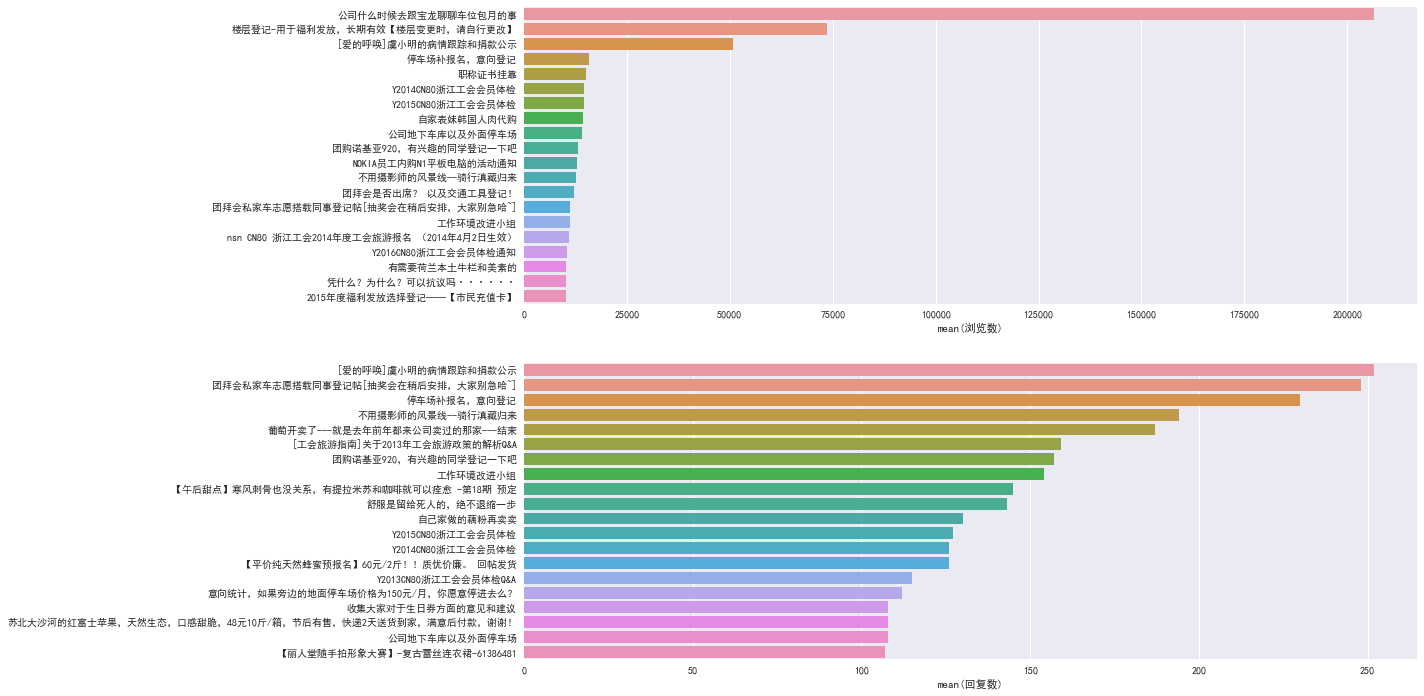

In [8]:
# 前20个最受欢迎的帖子的标题（浏览数最多，回复数最多）
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sorted_data_views = sorted_data_views.reset_index()
sns.barplot(y=sorted_data_views.index, x=sorted_data_views.浏览数, ax=ax1, orient='h')
ax1.set_yticklabels(sorted_data_views.标题)

sorted_data_replies = sorted_data_replies.reset_index()
sns.barplot(y=sorted_data_replies.index, x=sorted_data_replies.回复数, ax=ax2, orient='h') 
ax2.set_yticklabels(sorted_data_replies.标题)
plt.show()